# Number of hospitals of the biggest cities around the world
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>
Given the recent COVID-19 global pandemic, several major cities around the world will face infrastructure collapse related to insufficient healthcare, hospitals, and emergency services. Based on this reality, a city with 10 million citizens probably will have 1,500,000 infected people, who will need specialized healthcare and, in specific cases, intensive health care. Furthermore, between 200,000 and 500,000 infected people may die due to serious breathing complications.

Are those cities prepared to handle pandemics and catastrophic events? How many hospitals and intensive care services are in major cities around the world? What is the average citizen per hospital rate? How do those cities compare to each other? How are the number of hospitals and the population size related?


## Data <a name="data"></a>
To analyze this cenario, the geographic and demographic data of the biggest cities in the world were extracted from Wikipedia's related page. Complementary location data, the latitude and longitude coordinates, were obtained using Python's Geopy library. Finally, to perform the map plots and the comparative analysis, the list of hospitals of each city was extracted using Foursquare's API.

Combining the data extracted from Wikipedia, Geopy and Foursquare's API, after the data cleaning, there were 78 cities and 14 features on the data. The features are listed below:

* City name;
* Country;
* City definition;
* City population;
* City area (Km2);
* Metropolitan population;
* Metropolitan area (Km2);
* Urban population;
* Urban area (Km2);
* Demographic density (inhabitants per Km);
* Latitude;
* Longitude;
* Number of hospitals;
* Inhabitants per hospital.


In [1]:
import re, requests, string, folium
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn import preprocessing
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

First, we need to read the cities dataset from the [Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_cities).

In [2]:
wiki_cities = 'https://en.wikipedia.org/wiki/List_of_largest_cities'
cities_rq = requests.get(wiki_cities)

The following snippet pre-process the dataframe, forces the `int` type for numeric columns and removes invalid values. Finally, it shows the column types.

In [3]:
soup_cities = BeautifulSoup(cities_rq.text, 'html.parser')
table_cities = soup_cities.find_all('table')[1]
cities = pd.read_html(str(table_cities))[0]

# Removes columns multindex, renames and capitalizes the labels
cities.columns = cities.columns.map(' '.join).str.strip(' ')
cities.columns = map(lambda x: string.capwords(x), cities.columns)
cities.rename(columns={'City City': 'City', 'Country Country': 'Country', 'Skyline Skyline': 'Skyline','City Proper Definition': 'City Definition', 'City Proper Population': 'City Population', 'City Proper Area(km2)': 'City Area(km2)','Urban Area[9] Population': 'Urban Population','Urban Area[9] Area(km2)': 'Urban Area(km2)', 'Metropolitan Area Area(km2)': 'Metropolitan Area(km2)', 'Metropolitan Area Population': 'Metropolitan Population'}, inplace = True)

# Removes invalid characters from the columns
for col in ['City Population','City Area(km2)', 'Metropolitan Population','Metropolitan Area(km2)', 'Urban Area(km2)','Urban Population']: 
    cities[col] = cities[col].str.replace(r'\[[0-9A-Za-z]+\]', '')
    
# Process invalid values
cities['Metropolitan Population'].fillna(cities['City Population'], inplace=True)
cities['Metropolitan Area(km2)'].fillna(cities['City Area(km2)'], inplace=True)
cities.dropna(subset=['City Population'], inplace=True)
cities.drop(columns=['Skyline'], inplace=True)

# Forces int type for numeric columns
for col in ['City Population', 'City Area(km2)', 'Metropolitan Population', 'Metropolitan Area(km2)', 'Urban Area(km2)','Urban Population']:
    cities[col] = cities[col].str.replace(',', '').astype(float).astype(int)
    
cities = cities.sort_values(by='City Population', ascending=False).reset_index(drop=True)
cities['Demographic Density'] = cities['City Population'] / cities['City Area(km2)']
cities.dtypes

City                        object
Country                     object
City Definition             object
City Population              int64
City Area(km2)               int64
Metropolitan Population      int64
Metropolitan Area(km2)       int64
Urban Population             int64
Urban Area(km2)              int64
Demographic Density        float64
dtype: object

## Methodology <a name="methodology"></a>
This analysis will compare population size, city area, number of citizens per hospital and, the demographic density of the biggest cities in the world.

First, 10 cities will be selected, one of the biggest countries. Then, the hospital infrastructure will be plotted using Folium maps, to help understand the hospital infrastructure among different cities. Finally, a cluster model will be created, grouping the different cities, considering their similar features.

## Analysis <a name="analysis"></a>
### The list of the biggest cities in the world
First, lets take a look on the cities dataframe.

In [4]:
cities

,City,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
0,Chongqing,China,Municipality,30752000,82403,30752000,82403,8300000,1489,373.190296
1,Shanghai,China,Municipality,24183000,6341,24183000,6341,22125000,4015,3813.751774
2,Beijing,China,Municipality,21707000,16411,21707000,16411,19430000,4144,1322.710377
3,Delhi,India,National capital territory,16753235,1484,29000000,3483,28125000,2240,11289.241914
4,Chengdu,China,City (sub-provincial),16044700,14378,16044700,14378,12160000,1813,1115.920156
...,...,...,...,...,...,...,...,...,...,...
73,San Francisco,United States,Consolidated city-county,883305,122,4729484,6417,6100000,2865,7240.204918
74,"Washington, D.C.",United States,Federal district,702455,177,6263245,17009,7515000,5281,3968.672316
75,Boston,United States,City,694583,125,4875390,9033,7130000,9189,5556.664000
76,Düsseldorf,Germany,Urban district,642304,217,1555985,217,6660000,2655,2959.926267


For a better understanding of the data, the cities were plotted on a bar chart, sorted by the population size. Then, a scatter plot was created to show the relationship between the population size and the city area, grouping the cities by their respective countries and displaying the calculated demographic density of each city.

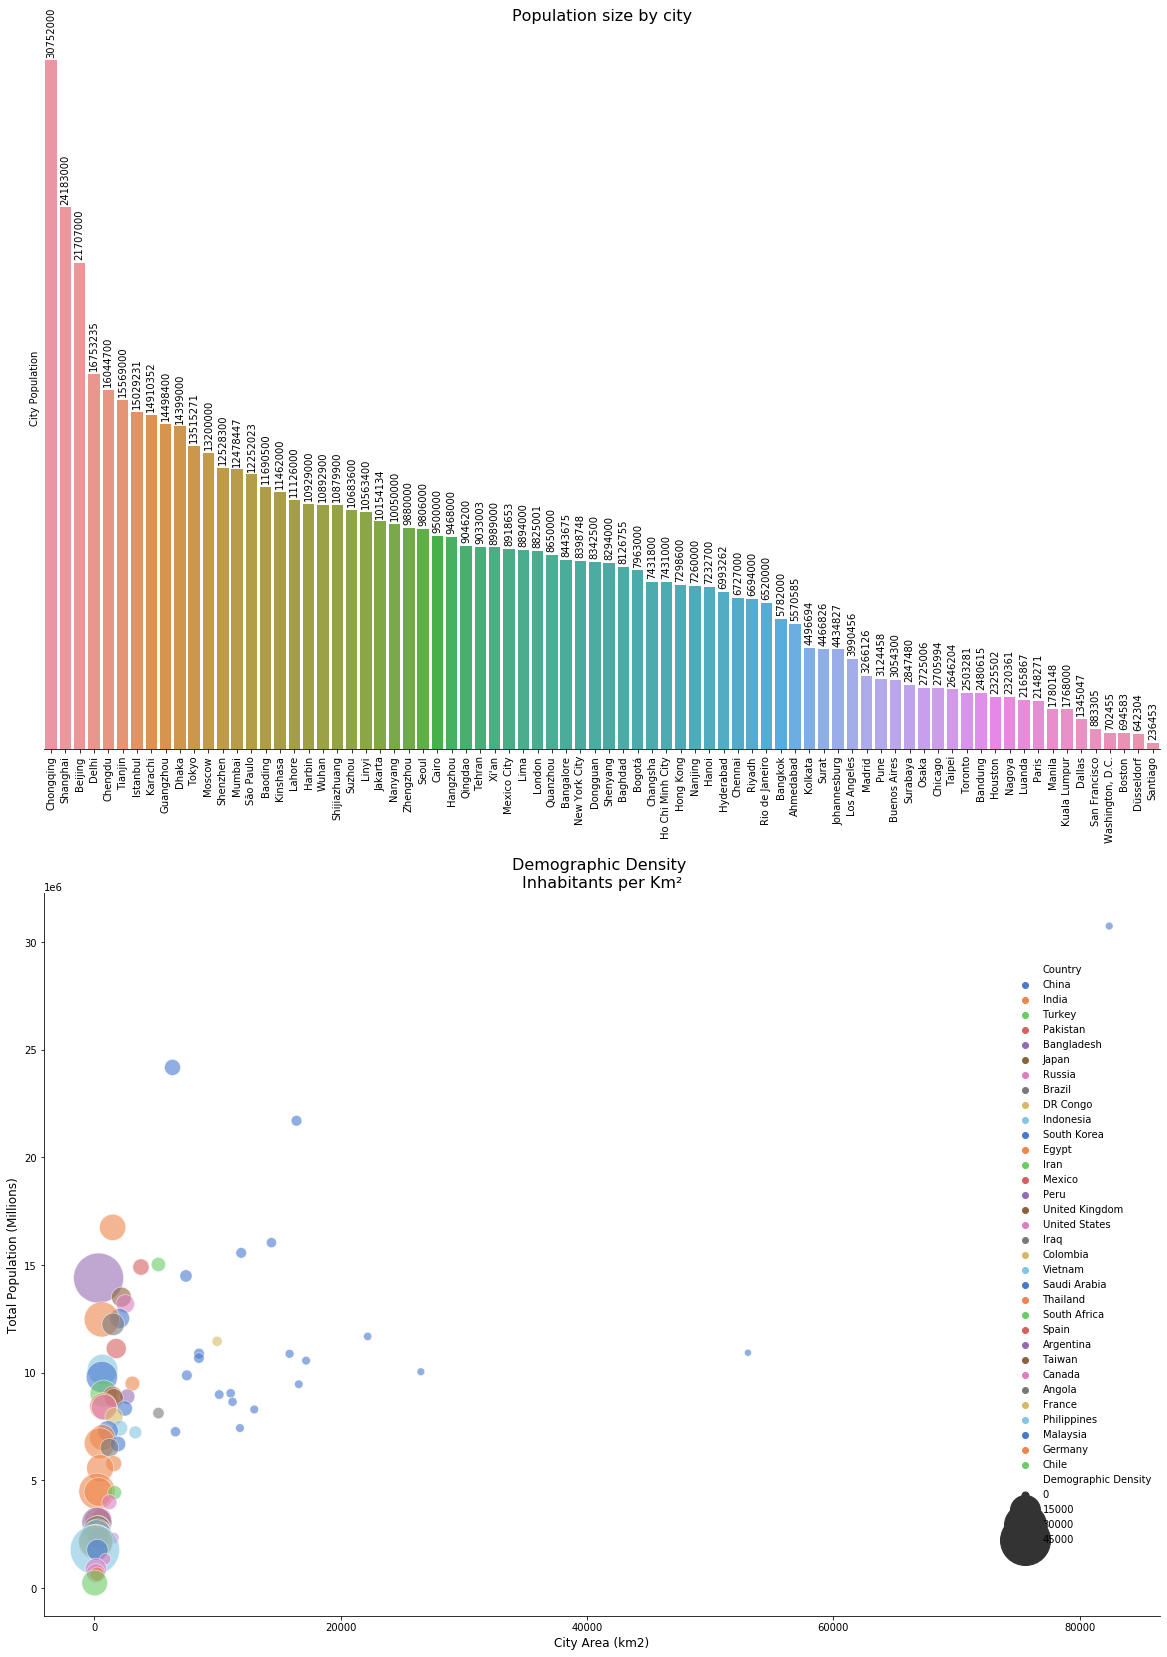

In [5]:
fig, ax = plt.subplots(figsize=(20, 16))
plt.subplots_adjust(bottom=-0.5)

s1 = plt.subplot(211)
bar = sns.barplot(cities['City'], cities['City Population'])
plt.xticks(rotation=90)
plt.yticks([])
plt.xlabel(None)
plt.xticks(fontsize=10)
plt.title('Population size by city', fontsize=16)
[s1.spines[side].set_visible(False) for side in ['left','right','top']]
[bar.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+150000),ha='center', va='bottom', c='black', fontsize=10, rotation=90) for p in bar.patches]

s2 = plt.subplot(212)
sns.scatterplot(x='City Area(km2)', y='City Population', hue='Country',
                data=cities, size='Demographic Density', sizes=(50,2500), alpha=.6, palette="muted")
plt.ticklabel_format(scilimits=(6,6), axis='y')
plt.ylabel('Total Population (Millions)', fontsize=12)
plt.xlabel('City Area (km2)', fontsize=12)
plt.title('Demographic Density \nInhabitants per Km²', fontsize=16)
plt.legend(loc='center right', frameon=False).get_frame().set_facecolor('none')
[s2.spines[side].set_visible(False) for side in ['right','top']]
plt.show();

### Biggest cities per country
Afterward, a new dataframe was created to help understand which countries have the biggest cities.

In [6]:
countries = cities[['City', 'Country', 'City Population','City Area(km2)','Demographic Density']].groupby('Country').sum().sort_values(by='City Population', ascending=False)
countries['Cities'] = cities[['City', 'Country']].groupby('Country').count()
countries.sort_values(by='Cities', ascending=False, inplace=True)
countries.head(10)

,City Population,City Area(km2),Demographic Density,Cities
Country,,,,
China,295631800,384199,37675.494979,24
India,69054182,5144,129363.584075,9
United States,21046090,5448,38354.642105,8
Japan,18560638,2742,25397.349493,3
Indonesia,15482229,1183,38170.414591,3
Pakistan,26036352,5552,10223.318605,2
Brazil,18772023,2742,13395.127286,2
Vietnam,14663700,5386,5780.779416,2
Canada,2503281,630,3973.461905,1


Then, I selected the biggest city from each country of the previous list. So, on the selected list, the following cities were selected.

In [7]:
biggest_cities = cities.groupby('Country').max().sort_values('City Population', ascending=False).reset_index()
biggest_cities.set_index('City', inplace=True)
biggest_cities.head(10)

,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
City,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683
Istanbul,Turkey,Metropolitan municipality,15029231,5196,15029231,5196,13860000,1360,2892.461701
Lahore,Pakistan,Metropolitan city,14910352,3780,14910352,3780,16900000,1036,6278.781038
Dhaka,Bangladesh,Capital city,14399000,338,14543124,338,18595000,453,42600.591716
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778
Moscow,Russia,Federal city,13200000,2511,13200000,2511,16555000,5698,5256.869773
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946
Kinshasa,DR Congo,City-province,11462000,9965,11462000,9965,12960000,583,1150.225790


For a better understanding of the cities comparison, a new barplot was created, showing the population size of each selected city.

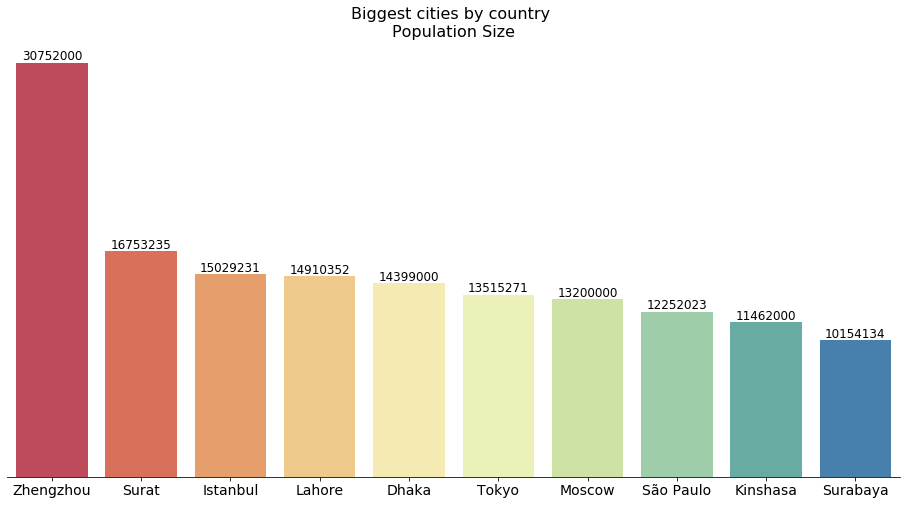

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
bar = sns.barplot(x=biggest_cities.index[:10], y='City Population', data=biggest_cities[:10], palette='Spectral')

[bar.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+0.2),ha='center', va='bottom', c='black', fontsize=12) for p in bar.patches]

plt.yticks([])
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(fontsize=14)
plt.title('Biggest cities by country \nPopulation Size', fontsize=16)
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
plt.show();

## Selected Cities

In [9]:
selected_cities = biggest_cities.loc[['Zhengzhou', 'Surat', 'Istanbul', 'Lahore', 'Dhaka', 'Tokyo','Moscow', 'São Paulo', 'Kinshasa', 'Surabaya']]
selected_cities.reset_index(drop=False, inplace=True)
selected_cities.set_index('City', inplace=True)
selected_cities

,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
City,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683
Istanbul,Turkey,Metropolitan municipality,15029231,5196,15029231,5196,13860000,1360,2892.461701
Lahore,Pakistan,Metropolitan city,14910352,3780,14910352,3780,16900000,1036,6278.781038
Dhaka,Bangladesh,Capital city,14399000,338,14543124,338,18595000,453,42600.591716
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778
Moscow,Russia,Federal city,13200000,2511,13200000,2511,16555000,5698,5256.869773
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946
Kinshasa,DR Congo,City-province,11462000,9965,11462000,9965,12960000,583,1150.225790


### Foursquare API: setting cities latitude and longitude
Next, an algorithm was created to get a list of hospitals in each city. Due to Foursquare API limitations, each list was limited to 50 venues per search in a radius of 50Km.


In [10]:
selected_cities['Latitude'], selected_cities['Longitude'] = [0,0]
geolocator = Nominatim(user_agent="covid-19")
for city, country in zip(selected_cities.index, selected_cities['Country']):
    try:
        location = geolocator.geocode('{}, {}'.format(city,country), timeout=10000)
        print(city, location.latitude, location.longitude)
        selected_cities.loc[city,'Latitude'] = location.latitude
        selected_cities.loc[city,'Longitude'] = location.longitude
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(c, e.message))

# Fix Moscow coordinates
selected_cities.loc['Moscow','Latitude'] = 55.751244
selected_cities.loc['Moscow','Longitude'] = 37.618423
selected_cities

Zhengzhou 34.7591877 113.6524076
Surat 21.1864607 72.8081281
Istanbul 41.0766019 29.052495
Lahore 31.5656079 74.3141775
Dhaka 23.7593572 90.3788136
Tokyo 35.6828387 139.7594549
Moscow 55.4792046 37.3273304
São Paulo -23.5506507 -46.6333824
Kinshasa -4.3217055 15.3125974
Surabaya -7.2459717 112.7378266


,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density,Latitude,Longitude
City,,,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725,34.759188,113.652408
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683,21.186461,72.808128
Istanbul,Turkey,Metropolitan municipality,15029231,5196,15029231,5196,13860000,1360,2892.461701,41.076602,29.052495
Lahore,Pakistan,Metropolitan city,14910352,3780,14910352,3780,16900000,1036,6278.781038,31.565608,74.314177
Dhaka,Bangladesh,Capital city,14399000,338,14543124,338,18595000,453,42600.591716,23.759357,90.378814
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778,35.682839,139.759455
Moscow,Russia,Federal city,13200000,2511,13200000,2511,16555000,5698,5256.869773,55.751244,37.618423
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946,-23.550651,-46.633382
Kinshasa,DR Congo,City-province,11462000,9965,11462000,9965,12960000,583,1150.225790,-4.321706,15.312597


### Hospitals per city
A Folium map was plotted for each one of the ten cities, showing the location of their respective hospitals and the geographical center of each city.

In [11]:
def build_map(city):
    city = city
    lat = selected_cities.loc[city, 'Latitude']
    lng = selected_cities.loc[city, 'Longitude']
    map = folium.Map(width=800, height=600,location=[lat, lng], zoom_start=12)
    folium.Marker(location=[lat, lng], tooltip=city, icon=folium.Icon(color='black', icon='bank', prefix='fa')).add_to(map)
    venues = explore(lat, lng)
    selected_cities.loc[city, 'Hospitals'] = len(venues)
    for v in venues:
        folium.Marker(location=[v['lat'], v['lng']], tooltip=v['name'], icon=folium.Icon(color='red', icon='hospital-o', prefix='fa')).add_to(map)
    return map

def explore(latitude, longitude):
    venues = []
    CLIENT_ID = 'OMVPO1DVXFDX4RZ1L1VCKMC45ZML0TK3JQP0JBIK4YAQAHFB'
    CLIENT_SECRET = '2HVRKXEVMZ5CEHUFXY5G3PFEHS4TQYQUBXXU51WZIS4R1PXF'
    VERSION = '20180604'
    category = '4bf58dd8d48988d196941735'
    radius = 30000
    limit = 50
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category, radius, limit)
    results = requests.get(url).json()
    #print('Responde Code:', results['meta']['code'])
    for r in results['response']['venues']:
        venues.append({'name': r['name'], 'lat': r['location']['lat'], 'lng': r['location']['lng']})
    return venues

### Zhengzhou, China

In [12]:
build_map('Zhengzhou')

### Surat, India

In [13]:
build_map('Surat')

### Istanbul, Turkey

In [14]:
build_map('Istanbul')

### Lahore, Pakistan

In [15]:
build_map('Lahore')

### Dhaka, Bangladesh

In [16]:
build_map('Dhaka')

### Tokyo, Japan

In [17]:
build_map('Tokyo')

### Moscow, Russia

In [18]:
build_map('Moscow')

### São Paulo, Brazil

In [19]:
build_map('São Paulo')

### Kinshasa, DR Congo

In [20]:
build_map('Kinshasa')

### Surabaya, Indonesia

In [21]:
build_map('Surabaya')

### Citizens per hospital
After the search on Foursquare API, the total number of hospitals of each city was set on a new dataframe. A new feature named `Inhabitants per hospital` was created to help visualize the relationship between the number of hospitals and the population size.

In [22]:
selected_cities['Inhabitants per Hospital'] = selected_cities['City Population'] / selected_cities['Hospitals']
selected_cities

,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density,Latitude,Longitude,Hospitals,Inhabitants per Hospital
City,,,,,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725,34.759188,113.652408,30.0,1.025067e+06
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683,21.186461,72.808128,41.0,4.086155e+05
Istanbul,Turkey,Metropolitan municipality,15029231,5196,15029231,5196,13860000,1360,2892.461701,41.076602,29.052495,50.0,3.005846e+05
Lahore,Pakistan,Metropolitan city,14910352,3780,14910352,3780,16900000,1036,6278.781038,31.565608,74.314177,50.0,2.982070e+05
Dhaka,Bangladesh,Capital city,14399000,338,14543124,338,18595000,453,42600.591716,23.759357,90.378814,49.0,2.938571e+05
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778,35.682839,139.759455,50.0,2.703054e+05
Moscow,Russia,Federal city,13200000,2511,13200000,2511,16555000,5698,5256.869773,55.751244,37.618423,50.0,2.640000e+05
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946,-23.550651,-46.633382,50.0,2.450405e+05
Kinshasa,DR Congo,City-province,11462000,9965,11462000,9965,12960000,583,1150.225790,-4.321706,15.312597,22.0,5.210000e+05


### Clustering
A cluster model was created using the K-means method, considering a number of `clusters = 4`. To build the cluster model, the following features were selected:

* city population
* city area (km2)
* demographic density
* number of hospitals
* inhabitants per hospital

Due to miss information on the metropolitan and urban columns, those columns were not included in the clustering model. Although, they are not so relevant, as seen on the correlation heatmap.

In [23]:
kmeans = KMeans(n_clusters=4)
selected_cities['Cluster'] = kmeans.fit_predict(selected_cities[['City Population', 'City Area(km2)', 'Demographic Density', 'Hospitals','Inhabitants per Hospital']])
selected_cities[['Country','City Population', 'City Area(km2)', 'Demographic Density', 'Hospitals','Inhabitants per Hospital','Cluster']]

,Country,City Population,City Area(km2),Demographic Density,Hospitals,Inhabitants per Hospital,Cluster
City,,,,,,,
Zhengzhou,China,30752000,82403,6611.050725,30.0,1.025067e+06,1
Surat,India,16753235,1484,21935.092683,41.0,4.086155e+05,2
Istanbul,Turkey,15029231,5196,2892.461701,50.0,3.005846e+05,2
Lahore,Pakistan,14910352,3780,6278.781038,50.0,2.982070e+05,2
Dhaka,Bangladesh,14399000,338,42600.591716,49.0,2.938571e+05,2
Tokyo,Japan,13515271,2191,12111.137778,50.0,2.703054e+05,0
Moscow,Russia,13200000,2511,5256.869773,50.0,2.640000e+05,0
São Paulo,Brazil,12252023,1521,8055.241946,50.0,2.450405e+05,0
Kinshasa,DR Congo,11462000,9965,1150.225790,22.0,5.210000e+05,3


A correlation model was also created to evaluate the relationship between the different features, focusing on the optimal features. Then, a heatmap was plotted to help visualize the strength of each relationship.

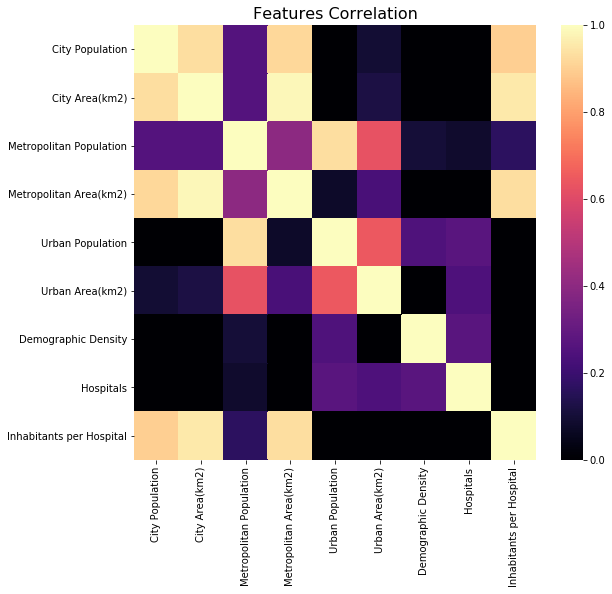

In [24]:
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(selected_cities.drop(columns=['Latitude','Longitude','Cluster']).corr(), cmap='magma', vmin=0)
plt.title('Features Correlation', fontsize=16)
plt.show();

Finally, a new scatter plots was created, comparing the cities, considering the processed clusters, among different correlations: population versus area; demographic density versus the number of hospitals; and demographic density versus inhabitants per hospital.

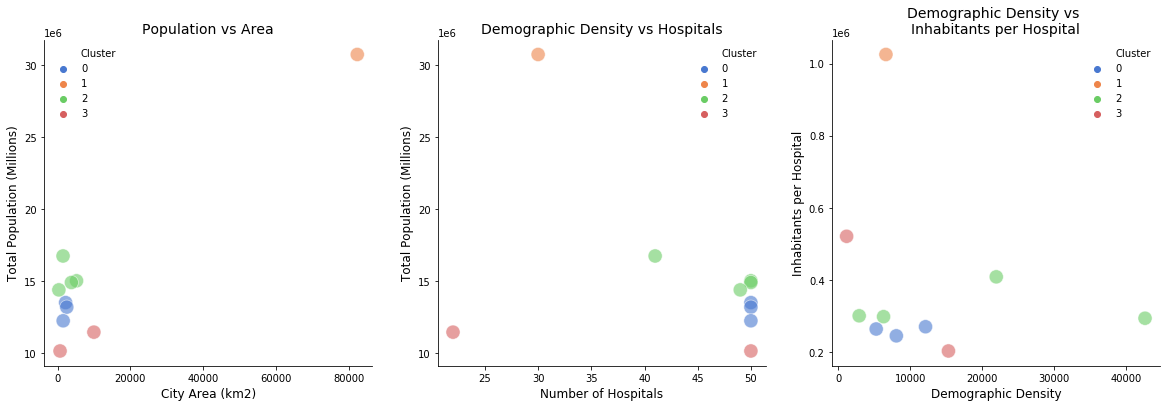

In [25]:
fig, ax = plt.subplots(figsize=(20, 6))

s1 = plt.subplot(131)
sns.scatterplot(data=selected_cities, x='City Area(km2)', y='City Population', alpha=.6, hue='Cluster', s=200, palette="muted")
plt.ticklabel_format(scilimits=(6,6), axis='y')
plt.ylabel('Total Population (Millions)', fontsize=12)
plt.xlabel('City Area (km2)', fontsize=12)
plt.title('Population vs Area', fontsize=14)
plt.legend(loc='upper left', frameon=False).get_frame().set_facecolor('none')
[s1.spines[side].set_visible(False) for side in ['right','top']]

s2 = plt.subplot(132)
sns.scatterplot(data=selected_cities, x='Hospitals', y='City Population', alpha=.6, hue='Cluster', s=200, palette="muted")
plt.ticklabel_format(scilimits=(6,6), axis='y')
plt.ylabel('Total Population (Millions)', fontsize=12)
plt.xlabel('Number of Hospitals', fontsize=12)
plt.title('Demographic Density vs Hospitals', fontsize=14)
plt.legend(loc='upper right', frameon=False).get_frame().set_facecolor('none')
[s2.spines[side].set_visible(False) for side in ['right','top']]

s3 = plt.subplot(133)
sns.scatterplot(data=selected_cities, x='Demographic Density', y='Inhabitants per Hospital', alpha=.6, hue='Cluster', s=200, palette="muted")
plt.ticklabel_format(scilimits=(6,6), axis='y')
plt.ylabel('Inhabitants per Hospital', fontsize=12)
plt.xlabel('Demographic Density', fontsize=12)
plt.title('Demographic Density vs \nInhabitants per Hospital', fontsize=14)
plt.legend(loc='upper right', frameon=False).get_frame().set_facecolor('none')
[s3.spines[side].set_visible(False) for side in ['right','top']]

plt.show();

Below you can check the final list, ordered descending by the number of inhabitants per hospital.

In [26]:
selected_cities[['Country','City Population', 'City Area(km2)', 'Demographic Density', 'Hospitals','Inhabitants per Hospital','Cluster']].sort_values('Inhabitants per Hospital')

,Country,City Population,City Area(km2),Demographic Density,Hospitals,Inhabitants per Hospital,Cluster
City,,,,,,,
Surabaya,Indonesia,10154134,664,15292.370482,50.0,2.030827e+05,3
São Paulo,Brazil,12252023,1521,8055.241946,50.0,2.450405e+05,0
Moscow,Russia,13200000,2511,5256.869773,50.0,2.640000e+05,0
Tokyo,Japan,13515271,2191,12111.137778,50.0,2.703054e+05,0
Dhaka,Bangladesh,14399000,338,42600.591716,49.0,2.938571e+05,2
Lahore,Pakistan,14910352,3780,6278.781038,50.0,2.982070e+05,2
Istanbul,Turkey,15029231,5196,2892.461701,50.0,3.005846e+05,2
Surat,India,16753235,1484,21935.092683,41.0,4.086155e+05,2
Kinshasa,DR Congo,11462000,9965,1150.225790,22.0,5.210000e+05,3


## Results and Discussion <a name="results"></a>
Analyzing the cluster model, we can identify evident patterns among the different cities. As mentioned in the methodology section, the population size and the area size had strong relevance on the clustering result. The four clusters are described as following below. 

**Bronze cluster**
This cluster number #3 contains two cities: Kinshasa in DR Congo and Surabaya in Indonesia. Those cities have respectively 1 million and 1.1 million inhabitants and, a rate of 521.000 and 203.082 inhabitants per hospital. Compared to the other clusters, those cities were labeled as bronze, considering mainly the population size below 1.2 million.

**Silver cluster**
The cluster number #2 contains three cities: São Paulo in Brazil, Moscow in Russia and Tokyo in Japan. All the cities look very similar considering both population size, with 12.2 million, 13.2 million and 13.5 million inhabitants respectively; and area size range, from 1,521Km2 to 2.511Km2. In a similar way, all the cities have a similar rate considering the narrow range between 245,040 to 270,305 inhabitants per hospital. Compared to the other clusters, those cities labeled as silver, considering the strong similarity on population size, area size and inhabitants per hospital rate.

**Gold cluster**
This cluster number #0 contains four of the biggest cities in the world: Dhanka in Bangladesh, Lahore in Pakistan, Istanbul in Turkey and Surat in India. All of those cities have a population size between 14.3 and 16.7 million inhabitants. The area size has a wider range, starting from 338Km2 to 5,196Km2. Considering the inhabitants per hospital rate, the four cities have a range between 287,980 and 349,025 inhabitants per hospital. Compared to the silver cluster, the gold cluster has similar cities with a population size slightly bigger.

**Platinum cluster**
The cluster number #1 contains just one city: Zhengzhou in China, the biggest city on the planet. This city alone has an amazing population size of 30.7 million inhabitants; a city area of 82,403Km2; and an inhabitant per hospital rate of 1,025,067.  Despite the population size, the demographic density of 6,611 inhabitants per kilometer isn't the biggest of the list, when compared with cities like Dhaka and Surat, with 42,600 and 21,935 inhabitants per Km, respectively. Given its huge proportions, Zhengzhou is labeled as platinum, with double the population size of the second place on the list; and eight times the area size of the second biggest area of the list. Zhengzhou is, with no doubt, the biggest city on the planet.

According to the model, the higher the demographic density, the higher the risk of infection among the citizens. To handle this situation, the lesser the inhabitants per hospital, the higher the chance of emergency care, especially on pandemic cases.

## Conclusion <a name="conclusion"></a>
The present analysis showed a strong relationship between the population size and the city area. Although, the population size is also related to the number of hospitals in a specific city. Besides that, the number of citizens per hospital probably has an important relationship with the healthcare services capacity and quality.

Cities with high demographic density and a high rate of citizens per hospital probably will face infrastructure issues during catastrophic events.

Due to the restricted number of features selected for this analysis, more research is necessary to evaluate precisely the correlation between different demographic, geographic, economic, environmental features and, the healthcare services capacity.